In [1]:
import os

import numpy as np
import h5py
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from tqdm import tqdm
import matplotlib
import seaborn as sns
sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

from utils import ECNUM, plot_class_accuracies, plot_confusion

annotations_path = 'data/annotations/merged_anno.txt'
embeddings_path = 'data/ec_vs_NOec_pide100_c50.h5'
val_data_fasta = 'data/nonRed_dataset/ec_vs_NOec_pide20_c50_val.fasta'
test_data_fasta = 'data/nonRed_dataset/ec_vs_NOec_pide20_c50_test.fasta'

In [2]:
val_identifiers = []
for sequence in SeqIO.parse(val_data_fasta, "fasta"):
    val_identifiers.append(sequence.id)

test_identifiers = []
for sequence in SeqIO.parse(test_data_fasta, "fasta"):
    test_identifiers.append(sequence.id)



annotations = {}
for i, annotation in tqdm(enumerate(open(annotations_path))):
        annotation_array = annotation.strip().split('\t')
        identifier = annotation_array[0]
        # ec number is an array with 4 entries. One entry for each component of the ec number
        ec_number = annotation_array[1].split(';')[0].split('.')
        annotations[identifier] = ec_number

253502it [00:01, 169200.05it/s]


In [3]:
val_id_ec = []
val_embeddings_ec = []
val_labels_ec = []
val_id = []
val_embeddings = []
val_labels = []
test_id_ec = []
test_embeddings_ec = []
test_labels_ec = []
test_id = []
test_embeddings = []
test_labels = []
train_id_ec = []
train_embeddings_ec = []
train_labels_ec = []
train_id = []
train_embeddings = []
train_labels = []
with h5py.File(embeddings_path, 'r') as h5:
    h5_keys = h5.keys()
    annotation_ids = annotations.keys()
    val_indices = np.random.randint(0,len(h5_keys),500)
    for id in tqdm(h5_keys):
        embedding = h5[id][:]
        if id in val_identifiers:
            if id in annotation_ids:
                val_embeddings_ec.append(embedding)
                val_labels_ec.append(annotations[id])
                val_id_ec.append(id)
                val_labels.append(1) # label as ec
            else:
                val_labels.append(0)
            val_id.append(id)# label as non ec
            val_embeddings.append(embedding)
        elif id in test_identifiers:
            if id in annotation_ids:
                test_embeddings_ec.append(embedding)
                test_labels_ec.append(annotations[id])
                test_id_ec.append(id)
                test_labels.append(1) # label as ec
            else:
                test_labels.append(0) # label as non ec
            test_id.append(id)
            test_embeddings.append(embedding)
        else:
            if id in annotation_ids:
                train_embeddings_ec.append(embedding)
                train_labels_ec.append(annotations[id])
                train_id_ec.append(id)
                train_labels.append(1) # label as ec
            else:
                train_labels.append(0) # label as non ec
            train_embeddings.append(embedding)
            train_id.append(id)


100%|██████████| 396978/396978 [12:34<00:00, 526.28it/s]


# Clustering

## EC vs Not-EC

### Clustering in sub-set of training

In [4]:
from sklearn.cluster import KMeans

In [58]:
from sklearn.metrics import confusion_matrix

In [6]:
km = KMeans(n_clusters=2, random_state=0)

In [7]:
index = np.random.choice(np.arange(len(train_embeddings)), replace=False, size=50000)

In [8]:
train_embeddings_array = np.array(train_embeddings)

In [9]:
train_labels_array = np.array(train_labels)

In [10]:
km.fit(train_embeddings_array[index])

KMeans(n_clusters=2, random_state=0)

In [11]:
cm = confusion_matrix(train_labels_array[index], km.labels_ ^1)

[Text(0, 0.5, 'non-enzyme'), Text(0, 1.5, 'enzyme')]

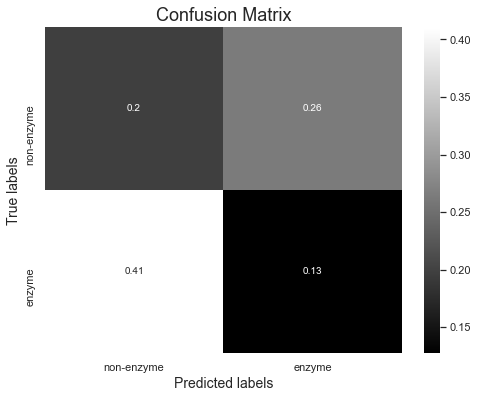

In [12]:
plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(cm/cm.sum(), annot=True, ax = ax, cmap ='gray'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['non-enzyme', 'enzyme'])
ax.yaxis.set_ticklabels(['non-enzyme', 'enzyme'])

### UMAP projection of Clustering

In [142]:
import umap

In [143]:
reducer = umap.UMAP(random_state=42, n_neighbors=15)

In [144]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
#palette = sns.color_palette("bright", len(np.unique(np.array(color))))
embedding = reducer.fit_transform(train_embeddings_array[index])

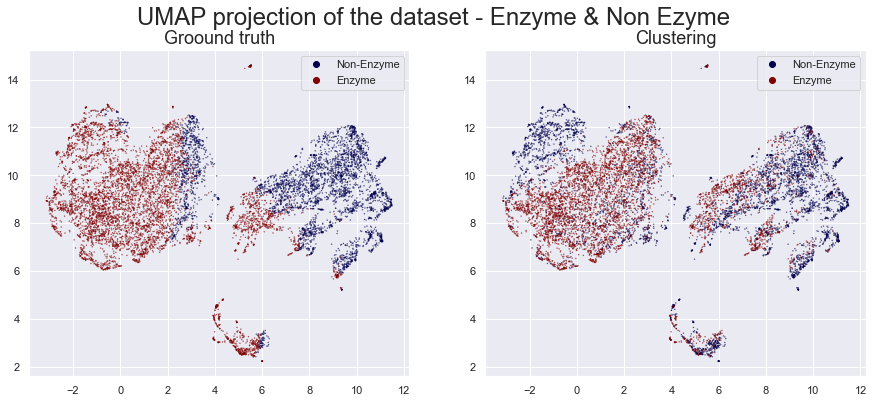

In [159]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (15,6))

scatter = ax[0].scatter(embedding[:, 0], embedding[:, 1], 
                        c=km.labels_ ^1, s=0.1, cmap=plt.get_cmap('seismic'))
fig.suptitle('UMAP projection of the dataset - Enzyme & Non Ezyme', fontsize = 24)
ax[0].set_title('Groound truth', fontsize = 18)
ax[0].legend(handles=scatter.legend_elements()[0], labels=['Non-Enzyme', 'Enzyme'])

scatter = ax[1].scatter(embedding[:, 0], embedding[:, 1], 
                        c=train_labels_array[index], s=0.1, cmap=plt.get_cmap('seismic'))
ax[1].set_title('Clustering', fontsize = 18)
ax[1].legend(handles=scatter.legend_elements()[0], labels=['Non-Enzyme', 'Enzyme'])

plt.show()

### Prediction in the train set

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

In [48]:
from sklearn.metrics.cluster import adjusted_rand_score

In [139]:
test_embeddings_array = np.array(test_embeddings)

In [140]:
y_pred = km.predict(test_embeddings_array)

In [141]:
accuracy_score(test_labels, y_pred)

0.8117408906882592

In [55]:
matthews_corrcoef(test_labels, y_pred)

0.29872307997957787

In [56]:
f1_score(test_labels, y_pred)

0.39999999999999997

In [57]:
adjusted_rand_score(train_labels_array[index].astype(np.int32), km.labels_)

0.12182382552875107

In [59]:
cm = confusion_matrix(test_labels, y_pred)

In [70]:
cm/cm.sum(axis=1)[:, np.newaxis]

array([[0.91811414, 0.08188586],
       [0.65934066, 0.34065934]])

In [71]:
cm

array([[370,  33],
       [ 60,  31]])

[Text(0, 0.5, 'non-enzyme'), Text(0, 1.5, 'enzyme')]

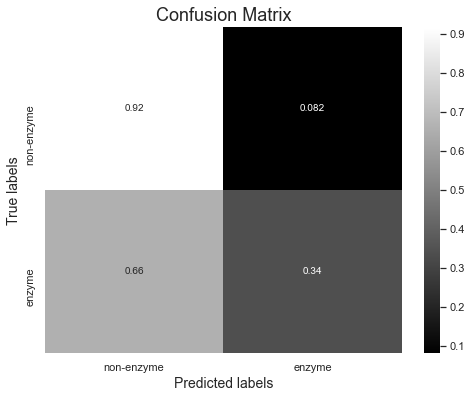

In [69]:
plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(cm/cm.sum(axis = 1)[:, np.newaxis], 
            annot=True, ax = ax, cmap ='gray'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['non-enzyme', 'enzyme'])
ax.yaxis.set_ticklabels(['non-enzyme', 'enzyme'])

## First EC Number 

In [72]:
km_ec1 = KMeans(n_clusters=7, random_state=0)

In [73]:
index_ec = np.random.choice(np.arange(len(train_embeddings_ec)), replace=False, size=10000)

In [74]:
train_embeddings_ec_array = np.array(train_embeddings_ec)
train_labels_ec = np.array(train_labels_ec)

In [77]:
km_ec1.fit(train_embeddings_ec_array[index_ec])

KMeans(n_clusters=7, random_state=0)

In [142]:
test_embeddings_ec_array = np.array(test_embeddings_ec)

In [146]:
y_ec_pred = km_ec1.predict(test_embeddings_ec_array)

In [154]:
adjusted_rand_score(test_label_ec, y_ec_pred +1)

0.016244265253936564

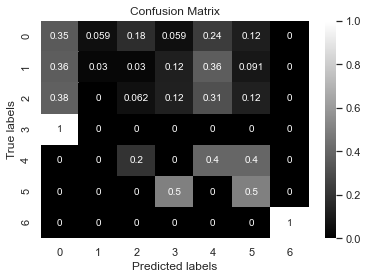

In [156]:
ax= plt.subplot()
sns.heatmap(cm_ec1/cm_ec1.sum(axis = 1)[:, np.newaxis], 
            annot=True, ax = ax, cmap ='gray'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Prediction in the train set

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score

In [48]:
from sklearn.metrics.cluster import adjusted_rand_score

In [83]:
test_embeddings_ec_array = np.array(test_embeddings_ec)

In [102]:
y_pred_ec = km_ec1.predict(test_embeddings_ec_array)

In [103]:
test_label_ec = np.array(test_labels_ec)[:,0].astype(np.int32)

In [108]:
accuracy_score(test_label_ec, y_pred_ec)

0.08791208791208792

In [55]:
matthews_corrcoef(test_labels, y_pred)

0.29872307997957787

In [56]:
f1_score(test_labels, y_pred)

0.39999999999999997

In [57]:
adjusted_rand_score(train_labels_array[index].astype(np.int32), km.labels_)

0.12182382552875107

In [59]:
cm = confusion_matrix(test_labels, y_pred)

In [70]:
cm/cm.sum(axis=1)[:, np.newaxis]

array([[0.91811414, 0.08188586],
       [0.65934066, 0.34065934]])

In [71]:
cm

array([[370,  33],
       [ 60,  31]])

[Text(0, 0.5, 'non-enzyme'), Text(0, 1.5, 'enzyme')]

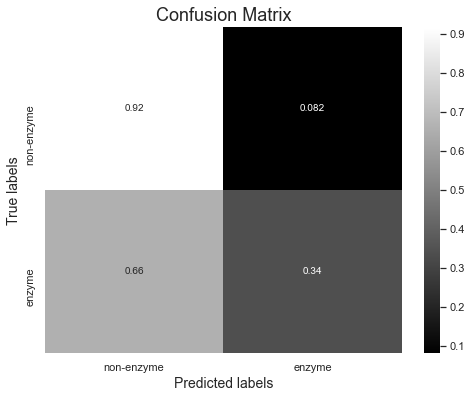

In [69]:
plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(cm/cm.sum(axis = 1)[:, np.newaxis], 
            annot=True, ax = ax, cmap ='gray'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['non-enzyme', 'enzyme'])
ax.yaxis.set_ticklabels(['non-enzyme', 'enzyme'])